# Classificadores 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ml

In [2]:
ml.plot.config_plot()

## MLP

In [3]:
class MLP:
    def __init__(self, inp, units, reset=False):
        self.inp = inp
        self.units = units
        self.reset = reset

        self.H = np.random.randn(self.inp, self.units)
        self.O = np.random.randn(self.units, 1)
    
    def _sigmoid(self, y):
        return 1 / (1 + np.exp(-y))

    def _sigmoid_line(self, y):
        return self._sigmoid(y) * (1 - self._sigmoid(y))
    
    def _get_classess(y_pred):
        return np.greater(y_pred, 0.5).astype(int).flatten()

    def fit(self, X, y, learning_rate=1e-2, epochs=10, return_losses=False, verbose=None):
        if self.reset:
            self.H = np.random.randn(self.inp, self.units)
            self.O = np.random.randn(self.units, 1)
        y = y.reshape(-1, 1)
        losses = []
        for e in range(epochs):
            h = X @ self.H
            h_A = self._sigmoid(h)
            o = h_A @ self.O
            o_A = self._sigmoid(o)

            grad_o_A = - (np.divide(y, o_A) - np.divide(1 - y, 1 - o_A))
            grad_o = grad_o_A * self._sigmoid_line(o)
            grad_O = h_A.T @ grad_o

            grad_h_A = grad_o_A @ self.O.T
            grad_h = grad_h_A * self._sigmoid_line(h)
            grad_H = X.T @ grad_h

            self.H -= grad_H * learning_rate
            self.O -= grad_O * learning_rate

            loss = ml.metrics.mse(o_A, y)
            losses.append(loss)
            if verbose and e % verbose == 0:
                accuracy = ml.metrics.accuracy(y, self._get_classess(o_A))
                print('Epoch {}: {} loss / {} accuracy'.format(e, loss, accuracy))
        if return_losses:
            return losses

    def predict(self, X):
        h = X @ self.H
        h_A = self._sigmoid(h)
        o = h_A @ self.O
        o_A = self._sigmoid(o)
        return np.greater(o_A, 0.5).astype(int).flatten()

## KNN

In [4]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.features = X
        self.classes = y
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i, r in enumerate(X):
            distances = [*map(lambda x: self._euclidean_distance(r, x), self.features)]
            nearest = np.argsort(distances)
            nearest = self.classes[nearest[:self.k]]
            y_pred[i] = self._mode(nearest)
        return y_pred
    
    def _euclidean_distance(self, a, b):
        return  np.sqrt(np.sum(np.square(a - b)))
    
    def _mode(self, a):
        (_, idx, counts) = np.unique(a, return_index=True, return_counts=True)
        index = idx[np.argmax(counts)]
        return a[index]

## K-fold

In [5]:
def k_fold(X, y, k, model):
    N = len(X)
    shuffle = np.random.permutation(N)
    X, y = X[shuffle], y[shuffle]
    k_size = N // k
    metrics = np.zeros(k)

    for j, i in enumerate(range(0, N, k_size)):
        val = np.zeros(len(X), dtype=bool)
        val[range(i, i + k_size)] = True
        model.fit(X[~val], y[~val])
        y_pred = model.predict(X[val])
        y_val = y[val]
        metrics[j] = ml.metrics.accuracy(y_val, y_pred)
    
    model.fit(X, y)
    return metrics

## Carregando dados

In [6]:
import pandas as pd

df = pd.read_csv('../data/data1.txt', header=None)
X = df[[0, 1]].values
y = df[2].values

X = ml.data.standard_scaler(X)

## Experimentos

### 5-fold MLP para n = {2, 3, 4}

Mean accuracy for fold 5 and n 2: 0.5599999999999999


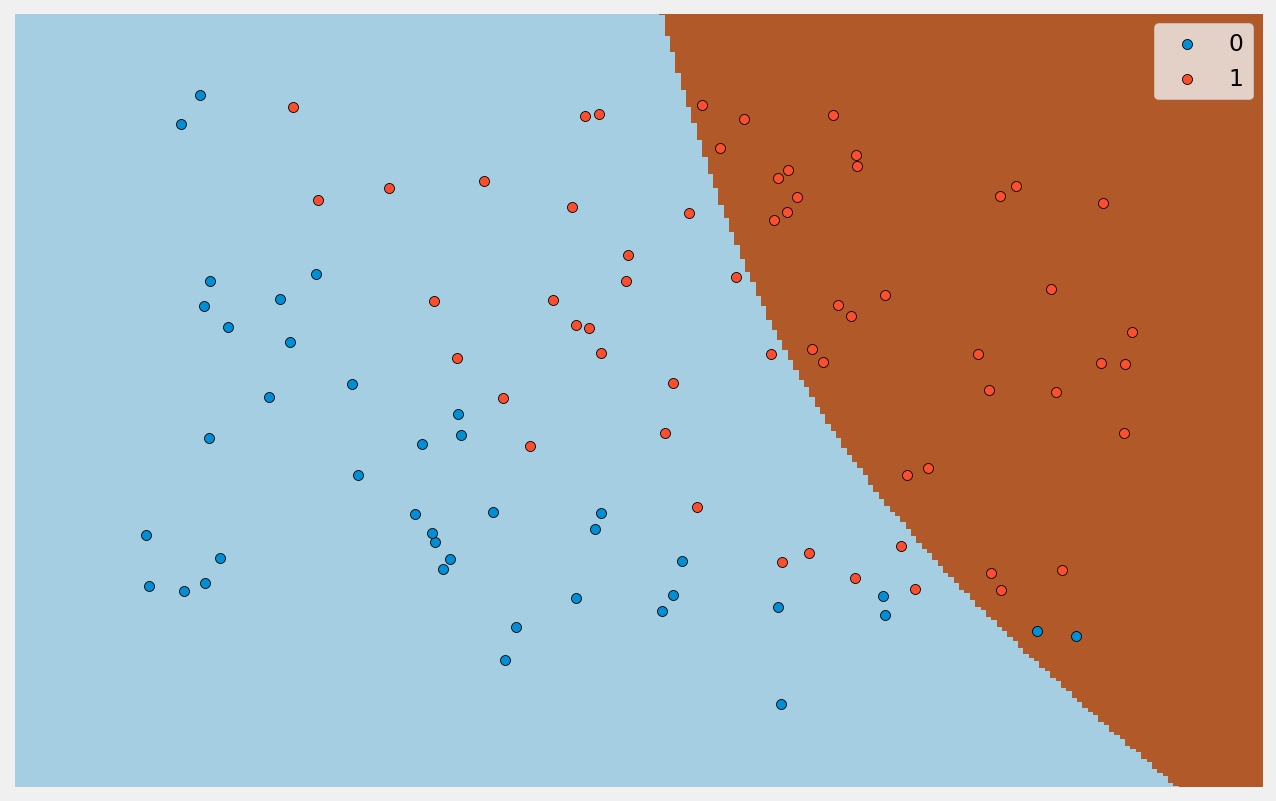

Mean accuracy for fold 5 and n 3: 0.78


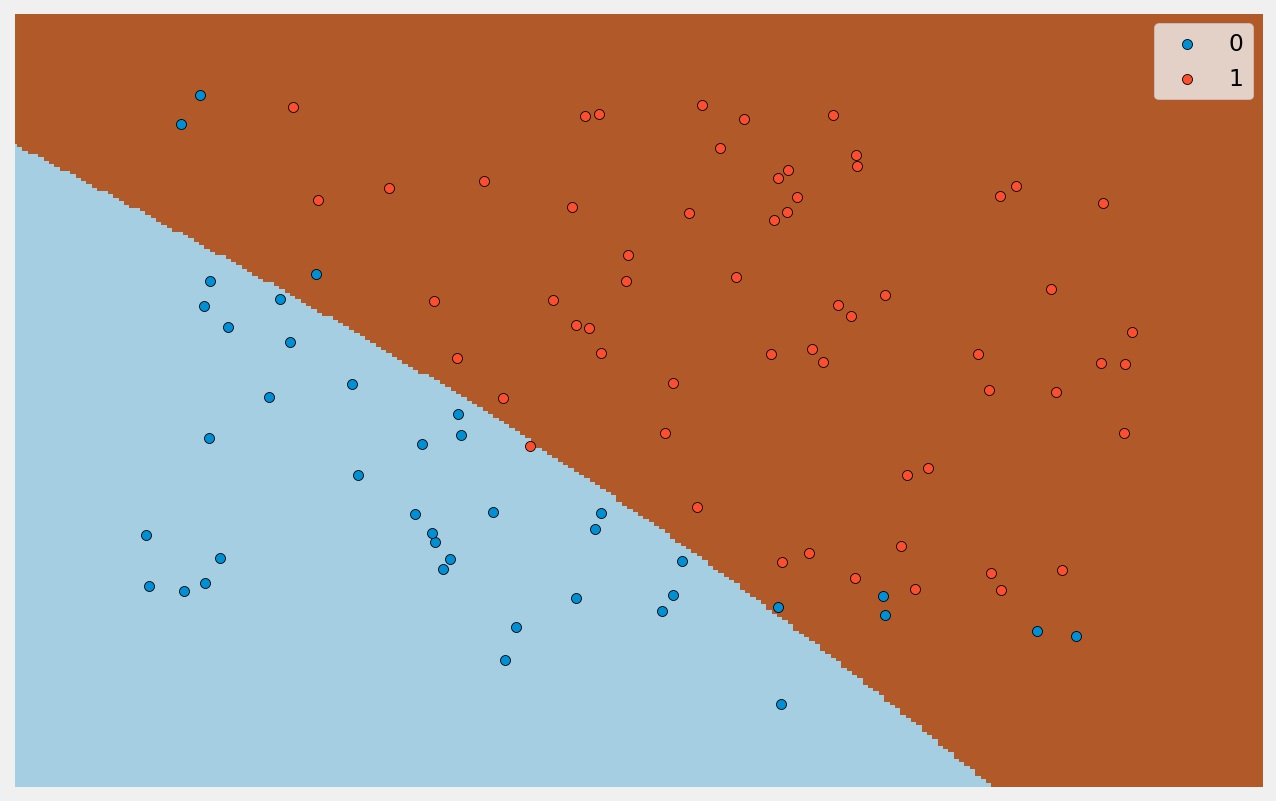

Mean accuracy for fold 5 and n 4: 0.85


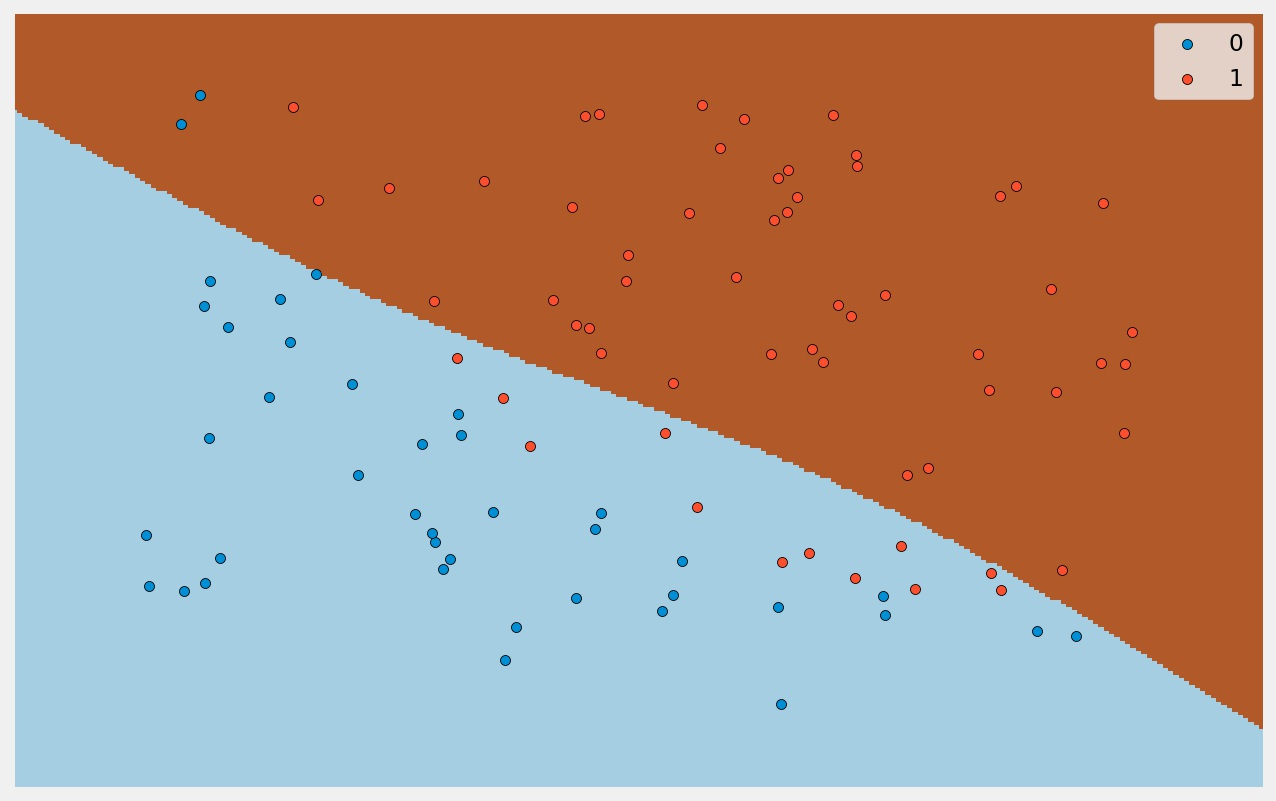

In [7]:
for n in [2, 3, 4]:
    mlp = MLP(2, n, reset=True)
    k_fold_accuracy = k_fold(X, y, 5, mlp)
    print('Mean accuracy for fold {} and n {}: {}'.format(5, n, k_fold_accuracy.mean()))
    ml.plot.plot_boundaries(X, y, mlp)
    plt.show()

### 5-fold KNN para k = {1, 2, 3}

Mean accuracy for fold 5 and k 1: 0.9299999999999999


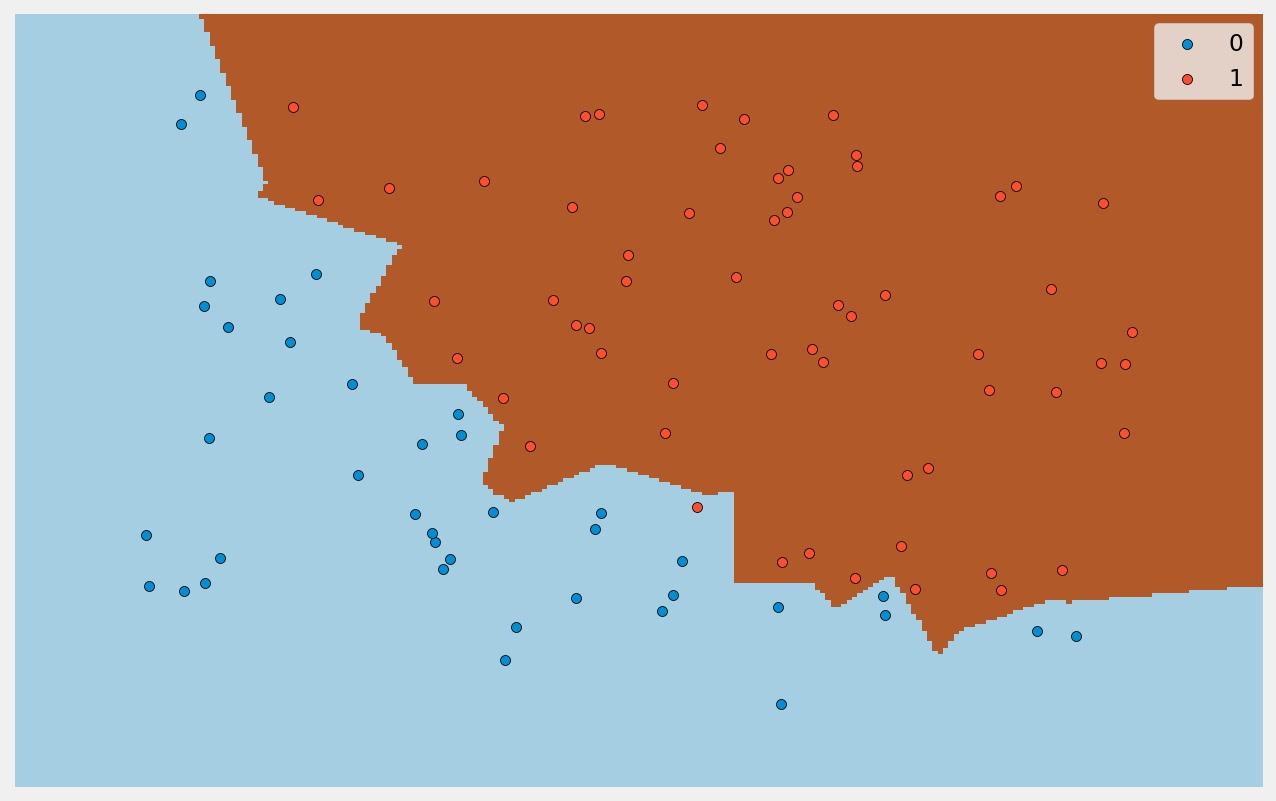

Mean accuracy for fold 5 and k 2: 0.8800000000000001


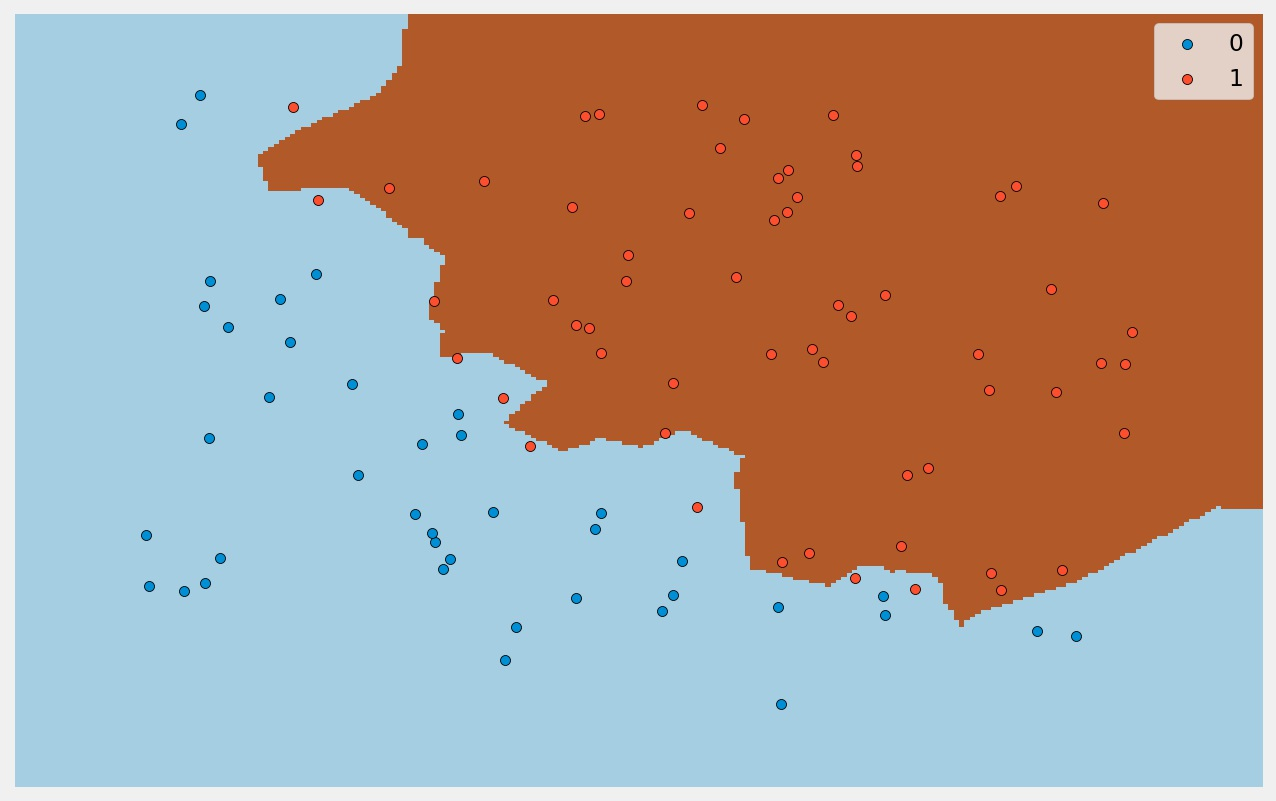

Mean accuracy for fold 5 and k 3: 0.9099999999999999


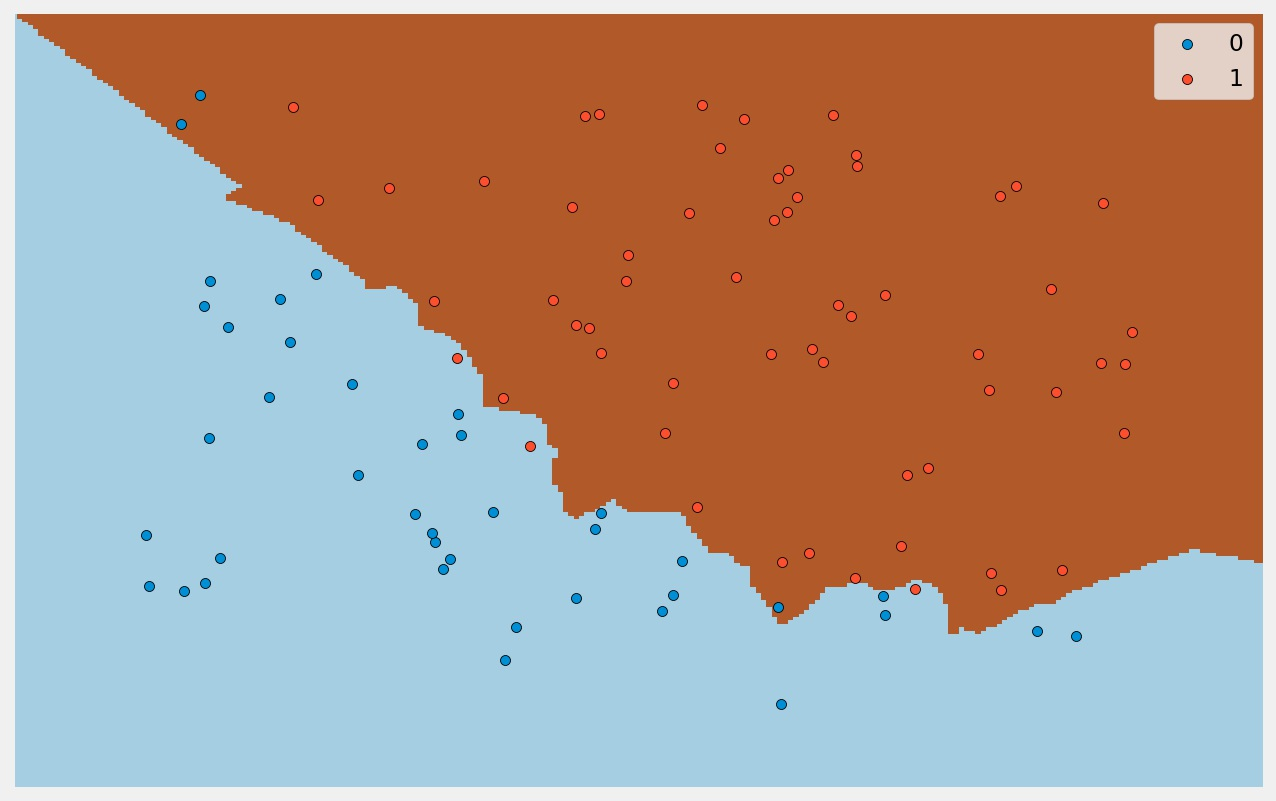

In [8]:
for k in [1, 2, 3]:
    knn = KNN(k)
    k_fold_accuracy = k_fold(X, y, 5, knn)
    print('Mean accuracy for fold {} and k {}: {}'.format(5, k, k_fold_accuracy.mean()))
    ml.plot.plot_boundaries(X, y, knn)
    plt.show()